#**Homography**
in this report we explain how to find homography matrix between two images from different view using predefined functions . in the following we explain the datails more percisely

##**import required libraries**

In [ ]:
!pip install opencv-contrib-python==4.4.0.44
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

##**Read original images**

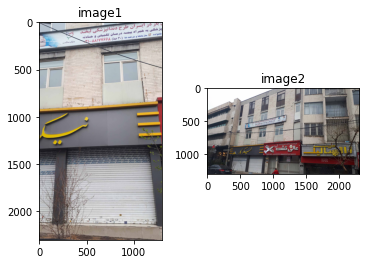

In [2]:
img1=np.array(plt.imread("im03.jpg").astype('float64'))
img2=np.array(plt.imread("im04.jpg").astype('float64'))

plt.subplot(121)
plt.imshow(img1.astype('int32'))
plt.title("image1")

plt.subplot(122)
plt.imshow(img2.astype('int32'))
plt.title("image2")

plt.show()

##**Corners**
to find corners in each image we use  `sift.detectAndCompute` from opencv package . this function compute keypoints and their descriptors . after calling this function , we show the keypoints for two image alongside each other. 

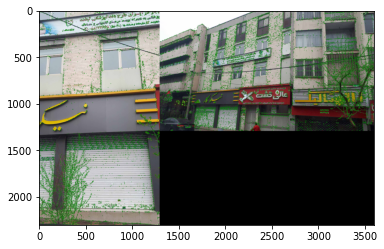

In [3]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1.astype(np.uint8),None)
kp2, des2 = sift.detectAndCompute(img2.astype(np.uint8),None)

green_rgb=[0,128,0]

test = cv2.drawKeypoints(img1.astype(np.uint8), kp1, None,green_rgb)
test2 = cv2.drawKeypoints(img2.astype(np.uint8), kp2, None,green_rgb)

temp=np.zeros([img1.shape[0]-img2.shape[0],img2.shape[1],3])
test22=cv2.vconcat([test2.astype(np.uint8),temp.astype(np.uint8)])
res13 = cv2.hconcat([test, test22])
plt.imshow(res13)
plt.imsave("res13_corners.jpg",res13)
plt.show()


##**Find matches between corners of two image**
to find matches in two image we use `bf.knnMatch(des1,des2,k=2)` from opencv package . this function compute two closest corner in image2 for each corner in image 1 and vice versa . after calling this function , we set the rule that    :          $\frac{L_{1}(first \ nearest)}{L_{1}(second \ nearest)} \leqslant 0.7$ 

this threshold helps us to save corresponding points with the least error. in the following you can see the matched corners(blue color) and all of corners(green)

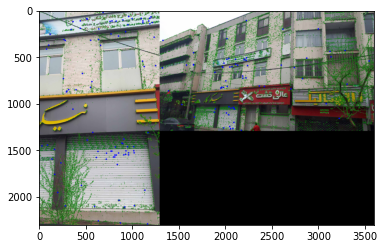

In [4]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
src_pts = np.float32([kp1[m.queryIdx].pt for m in good])
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ])

m1=np.copy(test)
m2=np.copy(test2)
for point in src_pts:
     cv2.circle(m1, tuple(point), 5,(0,0,255),5)

for point in dst_pts:
     cv2.circle(m2, tuple(point), 5,(0,0,255),5)     
temp=np.zeros([img1.shape[0]-img2.shape[0],img2.shape[1],3])
m2=cv2.vconcat([m2,temp.astype(np.uint8)])
res14_correspondences = cv2.hconcat([m1.astype(np.uint8), m2.astype(np.uint8)])
plt.imshow(res14_correspondences)
plt.imsave("res14_correspondences.jpg",res14_correspondences)
plt.show()

##**Plot lines between corresponding points**
to plot lines between matches in two image we use `cv2.drawMatchesKnn` from opencv package : 

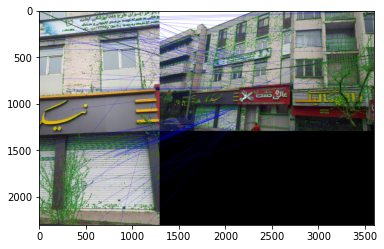

In [5]:
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(test.astype(np.uint8),kp1,test2.astype(np.uint8),kp2,good,None,[0,0,255],flags=2)

plt.imshow(img3)
plt.imsave("res15_matches.jpg",img3)
plt.show()

in order to distinguish the corresponding lines , we choose 20 random matched point and show the line between them : 

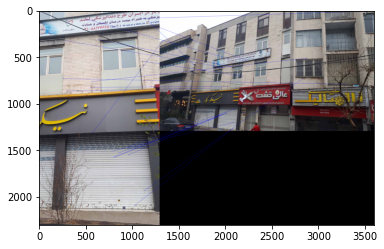

In [6]:
#Generate 20 random numbers between 0 and len(matches)
randomlist = random.sample(range(0, len(good)), 20)
listt=[]
for i in range(0,20):
   listt.append(good[int(randomlist[i])])
img4 = cv2.drawMatchesKnn(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,listt,None,[0,0,255],flags=2)

plt.imshow(img4)
plt.imsave('res16.jpg',img4)
plt.show()

##**Using RANSAC to omit outlier corners and find homography**
after finding corresponding points , it's time to find best homograpgy matrix. so we first have to omit outlier points and then make a homography matrix accroding to inlier points . in this part i use the function `cv2.RANSAC` with following paramters :

$\boxed{Number \ of \ itterations : 4000}$

$\boxed{accuracy : 99.5\%}$

$\boxed{Ransac \ Threshold : 5 \ pixel}$


In [7]:
MIN_MATCH_COUNT=5
matches = bf.knnMatch(des1,des2,k=2)
good=[]

# Apply ratio test
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append(m)
if len(good)>MIN_MATCH_COUNT:

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ])
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,ransacReprojThreshold=5,maxIters=4000,confidence=0.995)
    inverse_of_matrix=np.linalg.inv(M)
    inverse_of_matrix/=inverse_of_matrix[2,2]
    h,w = img1.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img3=np.zeros([img1.shape[0],img2.shape[1],3])
    img3[:img2.shape[0],:img2.shape[1],:]=np.copy(img2)
    temp=np.copy(img3)
    temp = cv2.polylines(temp,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

after using RANSAC we show both inlier with red line and correspnding points(contain inlier and outlier point) with blue line :

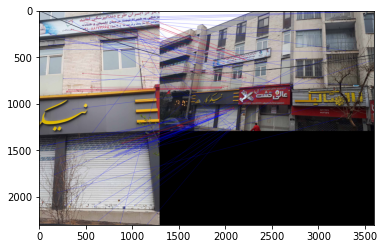

In [8]:
good=[]
# Apply ratio test
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append([m])
res17 = cv2.drawMatchesKnn(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,good,None,[0,0,255],flags=2)
fl=flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG + cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
res17 = cv2.drawMatchesKnn(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,good,res17,matchColor=(255, 0, 0), singlePointColor=(255, 0, 0),matchesMask=mask,flags=fl)
plt.imshow(res17)
plt.imsave("res17.jpg",res17)
plt.show()

after implementing Ransac if we compute homography from image2 to image 1 we have :


In [9]:
print(f"homography matrix = {inverse_of_matrix}")

homography matrix = [[ 3.70552615e+00  2.41612020e-01 -2.36140891e+03]
 [ 6.96891890e-02  2.34009011e+00 -1.17329356e+03]
 [ 1.14037303e-04 -1.52702605e-04  1.00000000e+00]]


$H=\begin{bmatrix}
3.70552615e+00 \ \ \ , \ \ 2.41612020e-01 \ \ \ \ \ , -2.36140891e+03\\
6.96891890e-02 \ \ ,2.34009011e+00\ , \ -1.17329356e+03\\ 
1.14037303e-04 \ \ \ \ \ \ , \ \ \ \  \  -1.52702605e-04 \  \ \ \ , \ \ \ \  1
\end{bmatrix}$

##**Show warped version of image1**

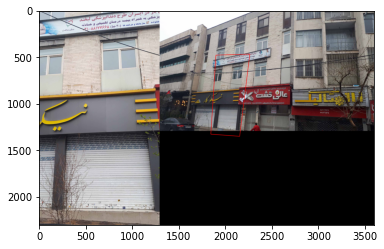

In [10]:
temp = cv2.normalize(temp,temp, 0, 255, cv2.NORM_MINMAX)    
res19 = cv2.hconcat([img1.astype(np.uint8), temp.astype(np.uint8)])
plt.imshow(res19)
plt.imsave("res19.jpg",res19)
plt.show()   

##**Do we have mismatches ?** 
if we plot the inlier lines we have the image below : 

as we can see , all of our inliers are true and they are not mismatch 

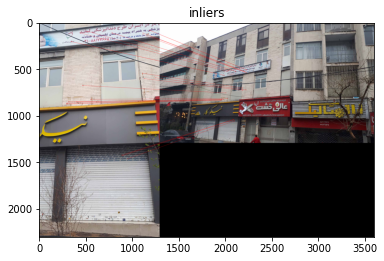

In [11]:
good=[]
# Apply ratio test
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good.append(m)
draw_params = dict(matchColor = (255,0,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask, # draw only inliers
                   flags = 2)
res18 = cv2.drawMatches(img1.astype(np.uint8),kp1,img2.astype(np.uint8),kp2,good,None,**draw_params)
plt.imshow(res18)
plt.title("inliers")
plt.show()

##**Normilizer**
we know that sometimes , homograpgy matrix map some of image's pixel to negative pixel when we warp the image . so we define a function `norimilize_matrix` that remove the negative offset of homography matrix and move the negative pixels to positive . 

In [12]:
def norimilize_matrix(src,hom):
    final=np.copy(hom)
    h,w=src.shape[:2]
    p=[[0,w,w,0],[0,0,h,h],[1,1,1,1]]
    p_prime=np.array(np.dot(hom, p))
    p_zegond=p_prime/p_prime[2,:]
    x_min=np.min(p_zegond[0,:])
    y_min=np.min(p_zegond[1,:])
    t=np.array([[1,0,0],[0,1,0],[0,0,1]])
    if(x_min<0):
       t[0,2]=x_min*-1.2
    if(y_min<0):  
       t[1,2]=y_min*-1.2
    return np.dot(t,final)   

##**final results**

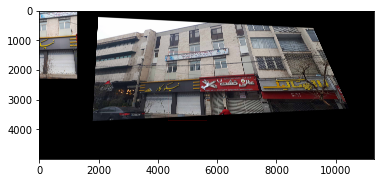

In [13]:
new=norimilize_matrix(img2,inverse_of_matrix)
dsz=(10000,5000)
out = cv2.warpPerspective(img2,new,dsz,flags=cv2.INTER_LINEAR)

dst1 = cv2.perspectiveTransform(dst,new)
temp=np.copy(out)
temp = cv2.polylines(temp,[np.int32(dst1)],True,255,3, cv2.LINE_AA)

con_ver=np.zeros([temp.shape[0]-img1.shape[0],img1.shape[1],3])
con_img1=cv2.vconcat([img1.astype(np.uint8),con_ver.astype(np.uint8)])
res20 = cv2.hconcat([con_img1, temp.astype(np.uint8)])

plt.imshow(res20.astype(np.uint8))
plt.imsave("res20.jpg",out.astype(np.uint8))
plt.imsave("res21.jpg",res20.astype(np.uint8))
plt.show()

##**Parameters**
$1) \ number \ of \ itteration \ in \ RANSAC=4000$

$2) \ H=\begin{bmatrix}
3.70552615e+00 \ \ \ , \ \ 2.41612020e-01 \ \ \ \ \ , -2.36140891e+03\\
6.96891890e-02 \ \ ,2.34009011e+00\ , \ -1.17329356e+03\\ 
1.14037303e-04 \ \ \ \ \ \ , \ \ \ \  \  -1.52702605e-04 \  \ \ \ , \ \ \ \  1
\end{bmatrix}$

$3) \ {accuracy : 99.5\%}$

$4) \ {Ransac \ Threshold : 5 \ pixel}$
